## Import Libraries

In [1]:
import cv2
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import albumentations as A
from albumentations.augmentations import transforms as AT
from albumentations.pytorch import ToTensorV2

c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Import Env File

In [2]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Parameters

In [3]:
classes = ['jogja', 'pekalongan']
image_size = (224, 224) 
test_split_ratio = 0.2

## GLCM Function

In [4]:
def extract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Tambahkan jarak dan sudut yang bervariasi
    distances = [1, 2, 3]  # Jarak pixel: 1, 2, 3
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Sudut: 0°, 45°, 90°, 135°

    # Hitung GLCM
    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Daftar fitur yang ingin diambil
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

    features = []

    # Ekstraksi setiap fitur dan flatten hasilnya
    for prop in props:
        prop_values = graycoprops(glcm, prop)  # shape = (len(distances), len(angles))
        features.extend(prop_values.flatten())

    return features

## Data Augmentation

In [5]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.05, 0.05), rotate=15, p=0.4)  # Pengganti ShiftScaleRotate
])

## Load The Dataset and Extract The Features

In [6]:
features = []
labels = []

for class_idx, class_name in enumerate(classes):
    folder = os.path.join(datasets_path, class_name)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, image_size)

        # Augmentasi gambar
        augmented = augment(image=image)
        aug_image = augmented['image']

        glcm_features_aug = extract_glcm_features(aug_image)
        features.append(glcm_features_aug)
        labels.append(class_idx)

features = np.array(features)
labels = np.array(labels)

## Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=test_split_ratio,
    random_state=42,
    stratify=labels  # Menjaga distribusi kelas tetap seimbang
)

In [8]:
# Melihat 10 baris pertama dari X_train
print("X_train sebelum normalisasi (10 baris pertama):")
print(X_train[:10])

X_train sebelum normalisasi (10 baris pertama):
[[3.69154508e+02 3.45250900e+02 1.71179332e+02 6.31383378e+02
  1.04196083e+03 3.45250900e+02 5.11956081e+02 6.31383378e+02
  1.70007545e+03 9.51829600e+02 8.99042360e+02 1.59414317e+03
  6.13068546e+00 5.65577430e+00 3.80076874e+00 8.26169841e+00
  1.10701818e+01 5.65577430e+00 7.00667632e+00 8.26169841e+00
  1.51044562e+01 1.02152423e+01 9.81550986e+00 1.44628277e+01
  7.07711375e-01 7.07299598e-01 7.31797938e-01 6.85501061e-01
  6.65154216e-01 7.07299598e-01 6.90434947e-01 6.85501061e-01
  6.39800518e-01 6.66031943e-01 6.66102541e-01 6.41632089e-01
  4.48673113e-01 4.49051760e-01 4.52225503e-01 4.45823185e-01
  4.41148970e-01 4.49051760e-01 4.48512890e-01 4.45823185e-01
  4.33729209e-01 4.42432967e-01 4.44799039e-01 4.35789795e-01
  9.78136551e-01 9.79571477e-01 9.89849990e-01 9.62640996e-01
  9.38419212e-01 9.79571477e-01 9.69671813e-01 9.62640996e-01
  8.99735303e-01 9.43849053e-01 9.46785438e-01 9.05957275e-01]
 [8.36822910e+03 7.89

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)        

In [10]:
# Melihat 10 baris pertama dari X_train
print("X_train sesudah normalisasi (10 baris pertama):")
print(X_train[:10])

X_train sesudah normalisasi (10 baris pertama):
[[-9.34483442e-01 -1.17102110e+00 -1.04665770e+00 -1.02345441e+00
  -9.01417070e-01 -1.17102110e+00 -1.21468450e+00 -1.02345441e+00
  -7.90692084e-01 -1.09487491e+00 -1.13517145e+00 -8.40484436e-01
  -1.53247882e+00 -1.87540908e+00 -1.68684499e+00 -1.65727868e+00
  -1.54965308e+00 -1.87540908e+00 -1.85107621e+00 -1.65727868e+00
  -1.45836548e+00 -1.80764948e+00 -1.80540892e+00 -1.52224799e+00
   2.69278373e+00  2.86260626e+00  2.74124004e+00  2.76478573e+00
   2.82373784e+00  2.86260626e+00  2.84338143e+00  2.76478573e+00
   2.93309748e+00  3.01397755e+00  2.91662648e+00  2.90024271e+00
   2.50200440e+00  2.55110367e+00  2.49464554e+00  2.52587423e+00
   2.56149568e+00  2.55110367e+00  2.55254857e+00  2.52587423e+00
   2.60042444e+00  2.64440402e+00  2.59866484e+00  2.59547209e+00
   1.07262168e+00  1.32059534e+00  1.04920377e+00  1.26094138e+00
   1.37121337e+00  1.32059534e+00  1.37930326e+00  1.26094138e+00
   1.44460487e+00  1.6268356

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
print("X_train shape:", X_train.shape)
print("X_train_pca shape:", X_train_pca.shape)

X_train shape: (157, 60)
X_train_pca shape: (157, 5)


In [13]:
# Melihat 10 baris pertama dari X_train_pca
print("X_train_pca (10 baris pertama):")
print(X_train_pca[:10])

X_train_pca (10 baris pertama):
[[-1.47457251e+01  4.87142159e+00 -1.64027524e+00 -7.75652652e-01
   4.98626374e-01]
 [ 1.87593351e+01  9.83792147e+00 -3.53568822e+00  1.87705545e+00
   2.22827121e+00]
 [-4.59389802e+00 -4.52350631e+00  3.52980714e-01  4.02713037e-01
  -7.46460042e-01]
 [ 6.53928497e+00  1.40460249e+00  4.07373942e+00 -3.05732483e+00
  -7.72254740e-01]
 [ 5.00513214e+00 -1.89319472e+00  1.10260252e+00 -1.34220166e+00
  -8.99459652e-01]
 [ 3.79026979e+00 -2.68992743e+00 -2.90685552e-01 -6.46648706e-01
  -3.20127534e-01]
 [-6.78213229e-01  1.09547664e+00  1.92405693e+00  7.65669005e-01
  -1.05003362e-02]
 [-4.49757727e+00 -2.41775035e+00  9.96782501e-01  4.60666012e-01
   5.63295095e-01]
 [ 5.24264625e+00 -2.75597609e+00 -2.33755565e+00  4.14065091e-01
  -6.28878322e-01]
 [-1.08519863e+01  9.35364426e+00 -3.60757526e+00 -1.93412813e-01
  -2.26412597e+00]]


## Train SVM

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Untuk kernel linear
param_grid_linear = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'class_weight': [None, 'balanced']
}

# Untuk kernel RBF
param_grid_rbf = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'class_weight': [None, 'balanced']
}

# Untuk kernel poly
param_grid_poly = {
    'kernel': ['poly'],
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.1, 0.5],
    'shrinking': [True, False],
    'tol': [1e-3],
    'class_weight': [None]
}

# Gabungkan semua grid
param_grid = [param_grid_linear, param_grid_rbf, param_grid_poly]

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_train_pca, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)


Fitting 5 folds for each of 188 candidates, totalling 940 fits
Best parameters: {'C': 10, 'class_weight': None, 'coef0': 0.5, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True, 'tol': 0.001}
Best cross-validation score: 0.7512096774193548


In [28]:
from sklearn.svm import SVC

# Gunakan parameter terbaik dari GridSearchCV
best_model = SVC(C=10, class_weight=None, coef0=0.5, degree=2, gamma='auto', kernel='poly', shrinking=True, tol=0.001)
best_model.fit(X_train_pca, y_train)


SVC(C=10, coef0=0.5, degree=2, gamma='auto', kernel='poly')

## Evaluates

In [29]:
# Evaluasi model
y_pred = best_model.predict(X_test_pca)

from sklearn.metrics import classification_report, confusion_matrix
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Akurasi: 0.6
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        20
           1       0.61      0.55      0.58        20

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40



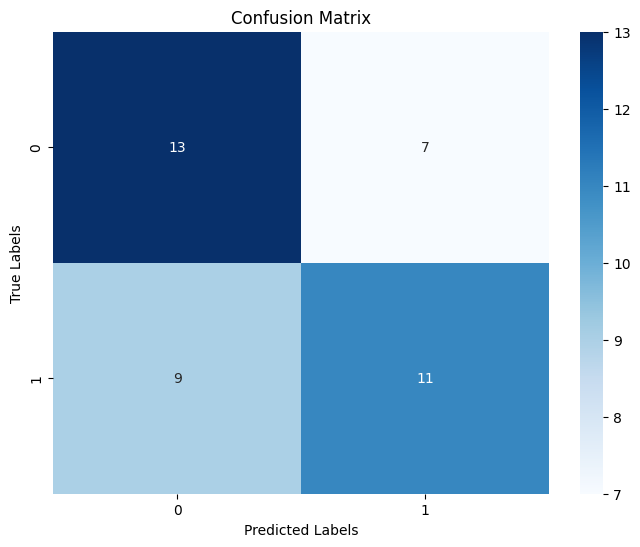

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan dengan heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Save The Model

In [31]:
from joblib import dump

# Simpan model ke file
dump(best_model, models_path+'/svm_glcm_model.joblib')
print("Model berhasil disimpan ke svm_glcm_model.joblib")

Model berhasil disimpan ke svm_glcm_model.joblib
